# Image Approximation with Orthogonal Bases

*Based on Gabriel Peyré's Numerical Tours.*

In this notebook, you will use several orthogonal bases to perform non-linear image approximation:

- Fourier
- Wavelets (which is at the heart of JPEG-2000)
- Cosine
- Local cosine (which is at the heart of JPEG).

In [1]:
# Imports.
import numpy as np
import matplotlib.pyplot as plt

from scipy import fftpack

from skimage.data import astronaut
from skimage.transform import resize
from skimage.color import rgb2gray

## Introduction: Best $M$-terms Non-linear Approximation

This tour makes use of an orthogonal base $ \mathcal B = \{ \psi_m \}_{m=0}^{N-1} $
of the space $\mathbb R^N$ of images with $N=n\times n$ pixels.


The best $M$-term approximation of $f$ is obtained by a non-linear
thresholding

$$ f_M = \sum_{ |\langle f, \psi_m\rangle|>T}   \langle f, \psi_m\rangle \psi_m, $$
where the value of $T>0$ should be carefully selected so that only
$M$ coefficients are not thresholded, i.e.

$$ m = \#\{m ~\text{ s.t. }~ |\langle f, \psi_m\rangle |>T \}.$$


**The goal is to use an ortho-basis $ \mathcal B $ so that the error $ ||f-f_M|| $
decays as fast as possible when $M$ increases, for a large class of
images.**

## Loading an image

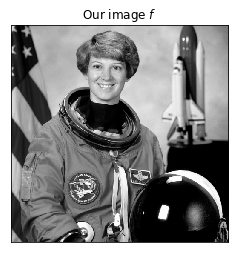

In [2]:
n = 512 # Size of the image
f = astronaut() # Loading the image.
f = resize(f, (n, n)) # Resizing the image.
f = rgb2gray(f) # Converting the image to grayscale.

# Plotting the image.
plt.title("Our image $f$")
plt.imshow(f, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.show()

## Fourier Approximation

The discrete 2-D Fourier atoms are defined as:
$$ \psi_m(x) = \frac{1}{\sqrt{N}} e^{ \frac{2i\pi}{n} ( x_1 m_1 + x_2 m_2 ) },  $$
where $ 0 \leq m_1,m_2 < n $ indexes the frequency.


The set of inner products $ \{ \langle f, \psi_m\rangle \}_m $ is computed in
$O(N \log(N))$ operations with the 2-D Fast Fourier Transform (FFT)
algorithm.

----------------------

**Question 1:**
- Compute the vector `f_fourier` of coefficients $\langle f, \psi_m\rangle$ using the function `np.fft.fft2`. Do not forget to divide by `n`!
- Display the log-magnitude of the `f_fourier`: $\log_{10}(10^{-6} + |\hat f|)$.
- You may want to use `np.fft.fftshift` to center the visualization.

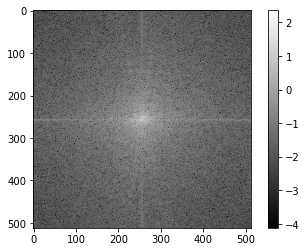

In [3]:
# Compute the fourier transform of the image.
f_fourier = np.fft.fft2(f) / n

# Compute the log-magnitude of the fourier transform.
log_magnitude = np.log10(1e-6 + np.abs(np.fft.fftshift(f_fourier)))

# Plotting the log-magnitude of the fourier transform.
plt.imshow(log_magnitude, cmap='gray')
plt.colorbar()
plt.show()

----------------------

An image is recovered from a set of coefficients `f_fourier` using the inverse
Fourier Transform (`np.fft.ifft2`). Thresholding is thus perform as follows.

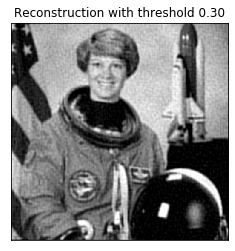

In [4]:
threshold = 0.3 # Set the threshold.

# Set the coefficients smaller than the threshold to zero.
masked_f_fourier = f_fourier * (np.abs(f_fourier) > threshold)

# Compute the inverse fourier transform of the masked fourier transform.
# Notice that we multiply by n again!
f_reconstructed = np.real(np.fft.ifft2(masked_f_fourier * n))

# Plot the reconstructed image.
plt.title("Reconstruction with threshold %.2f" % threshold)
plt.imshow(f_reconstructed, cmap='gray', vmin=0, vmax=1)
plt.xticks([])
plt.yticks([])
plt.show()

------------------

**Question 2:** Select a threshold that $M=N/100$ coefficients are kept and display the approximation. Do the same for $M=N/20$.

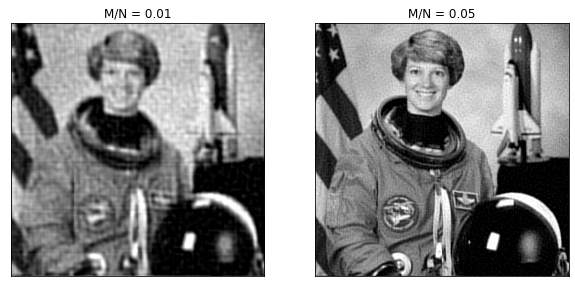

In [5]:
# Initialize the subplots.
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Set the threshold.
T = np.quantile(np.abs(f_fourier), .99)

# Compute the approximation.
masked_f_fourier = f_fourier * (np.abs(f_fourier) > T)
f_reconstructed = np.real(np.fft.ifft2(masked_f_fourier * n))

# Plot the approximation.
axes[0].set_title("M/N = %.2f" % np.mean(np.abs(f_fourier) > T))
axes[0].imshow(f_reconstructed, cmap='gray', vmin=0, vmax=1)
axes[0].set_xticks([])
axes[0].set_yticks([])

# Set the threshold.
T = np.quantile(np.abs(f_fourier), .95)

# Compute the approximation.
masked_f_fourier = f_fourier * (np.abs(f_fourier) > T)
f_reconstructed = np.real(np.fft.ifft2(masked_f_fourier * n))

# Plot the approximation.
axes[1].set_title("M/N = %.2f" % np.mean(np.abs(f_fourier) > T))
axes[1].imshow(f_reconstructed, cmap='gray', vmin=0, vmax=1)
axes[1].set_xticks([])
axes[1].set_yticks([])

# Display the subplots.
plt.show()

--------------------

The best $M$-term approximation error is computed using the
conservation of energy as

$$ \varepsilon[M]^2 = ||f-f_M||^2 = \sum_{ |\langle f, \psi_m\rangle| \leq T } |\langle f, \psi_m\rangle|^2.  $$


If one denotes by $ \{ c_R[k] \}_{k=0}^{N-1} $ the set of
coefficient magnitudes $ |\langle f, \psi_m \rangle| $ ordered by *decaying*
magnitudes, then this error is easily computed as
$$ \epsilon[M]^2 = \sum_{k=M}^{N-1} c_R[k]^2
    = ||f||^2 - \sum_{k=0}^{M-1} c_R[k]^2. $$
This means that $\epsilon^2$ is equal to
$||f||^2$ minus the discrete primitive of $ c_R^2 $.

-------

**Question 3:** Compute and display in log scale the ordered coefficients $c_R$.

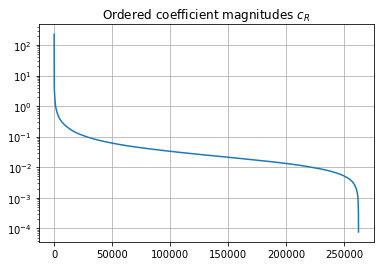

In [6]:
ordered_magnitudes = np.sort(np.abs(f_fourier).ravel())[::-1]

plt.title("Ordered coefficient magnitudes $c_R$")
plt.plot(ordered_magnitudes)
plt.yscale("log")
plt.grid()
plt.show()

**Question 4:** Compute and display in log-scale the non-linear approximation
error $\epsilon[M]^2$.
Store the values of $\epsilon[M]^2$ in a vector $err\_fft$.

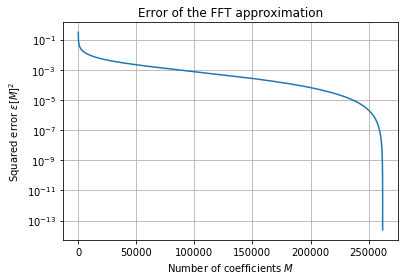

In [7]:
err_fft = np.sum(f**2) - np.cumsum(ordered_magnitudes**2)
plt.title("Error of the FFT approximation")
plt.plot(err_fft/np.sum(f**2))
plt.xlabel("Number of coefficients $M$")
plt.ylabel("Squared error $\\varepsilon [M]^2$")
plt.grid()
plt.yscale("log")

Wavelet Approximation
---------------------
The Wavelet basis of continuous 2-D functions is defined by
by scaling and translating three mother
atoms $ \{\psi^H,\psi^V,\psi^D\} $:
$$ \psi_{j,n}^k(x) = \frac{1}{2^j}\psi^k\left(\frac{x-2^j n}{2^j}\right)  $$


Non-linear wavelet approximation is a the heart of the JPEG-2000
compression standard.


The set of inner products $ \{ \langle f, \psi_m\rangle \}_m $ is computed in
$O(N)$ operations with the 2-D Fast Wavelet Transform
algorithm.

In [8]:
# Define a bunch of functions for wavelets.

# Circularly shift a 1D vector
circshift1d = lambda x, k: np.roll(x, -k, axis=0)

# subsampling along dimension d by factor p=2
subsampling = lambda x, d: x[::2, :] if d == 1 else x[:, ::2]

# Reverse a vector.
reverse = lambda x: x[::-1]

# up-sampling along dimension d by factor p=2
def upsampling(x, d):
    if d == 1:
        y = np.zeros((2 * x.shape[0], x.shape[1]))
        y[::2, :] = x
    else:
        y = np.zeros((x.shape[0], 2 * x.shape[1]))
        y[:, ::2] = x
    return y


# Circular convolution along dimension d. h should be small and with odd size
def cconv(x, h, d):
    y = np.zeros_like(x)
    if d == 1:
        for i in range(len(h)):
            y += h[i] * circshift1d(x, i - (len(h) - 1) // 2)
    else:
        y = cconv(x.T, h, 1).T
    return y


# Compute orthogonal wavelet transform
def wavelet_transform_2d(f, j_min, h):
    Jmax = int(np.log2(f.shape[1])) - 1  # Define the maximum scale.

    # Compute the g filter.
    u = np.power(-np.ones(len(h) - 1), range(1, len(h)))
    g = np.concatenate(([0], h[-1:0:-1] * u))

    # Perform the wavelet transform.
    fW = f.copy()
    for j in np.arange(Jmax, j_min - 1, -1):
        i_max = 2 ** (j + 1)

        coarse = subsampling(cconv(fW[:i_max, :i_max], h, 1), 1)
        detail = subsampling(cconv(fW[:i_max, :i_max], g, 1), 1)
        fW[:i_max, :i_max] = np.concatenate((coarse, detail), axis=0)

        coarse = subsampling(cconv(fW[:i_max, :i_max], h, 2), 2)
        detail = subsampling(cconv(fW[:i_max, :i_max], g, 2), 2)
        fW[:i_max, :i_max] = np.concatenate((coarse, detail), axis=1)

    return fW


# Compute inverse orthogonal wavelet transform
def inverse_wavelet_transform_2d(f, j_min, h):
    Jmax = int(np.log2(f.shape[1])) - 1  # Define the maximum scale.

    # Compute the g filter.
    u = np.power(-np.ones(len(h) - 1), range(1, len(h)))
    g = np.concatenate(([0], h[-1:0:-1] * u))

    # Perform the inverse wavelet transform.
    f1 = f.copy()
    for j in np.arange(j_min, Jmax + 1):
        i_min, i_max = 2**j, 2 ** (j + 1)

        A = f1[:i_max, :i_max]
        coarse, detail = A[:i_min, :], A[i_min:i_max, :]
        coarse = cconv(upsampling(coarse, 1), h[::-1], 1)
        detail = cconv(upsampling(detail, 1), g[::-1], 1)
        A = coarse + detail

        coarse, detail = A[:, :i_min], A[:, i_min:i_max]
        coarse = cconv(upsampling(coarse, 2), h[::-1], 2)
        detail = cconv(upsampling(detail, 2), g[::-1], 2)
        A = coarse + detail

        f1[:i_max, :i_max] = A
    return f1

# plot wavelets coefficients.
def plot_wavelet(fW, j_min=0):

    def rescale(f, a=0, b=1):
        v = f.max() - f.min()
        g = (f - f.min()).copy()
        if v > 0:
            g = g / v
        return a + g * (b - a)

    def rescaleWav(A):
        v = abs(A).max()
        B = A.copy()
        if v > 0:
            B = 0.5 + 0.5 * A / v
        return B

    j_max = int(np.log2(fW.shape[1])) - 1
    U = fW.copy()
    for j in np.arange(j_max, j_min - 1, -1):
        i_min, i_max = 2**j, 2 ** (j + 1)
        U[:i_min:, i_min:i_max:] = rescaleWav(U[:i_min:, i_min:i_max:])
        U[i_min:i_max:, :i_min:] = rescaleWav(U[i_min:i_max:, :i_min:])
        U[i_min:i_max:, i_min:i_max:] = rescaleWav(U[i_min:i_max:, i_min:i_max:])

    # coarse scale
    U[:i_min:, :i_min:] = rescale(U[:i_min:, :i_min:])

    # plot underlying image
    plt.imshow(U, cmap="gray")

    # display crosses
    for j in np.arange(j_max, j_min - 1, -1):
        i_min, i_max = 2**j, 2 ** (j + 1)
        plt.hlines(i_min, xmin=0, xmax=i_max - 1, color="r")
        plt.vlines(i_min, ymin=0, ymax=i_max - 1, color="r")
    
    # display box
    plt.vlines(n - 1, ymin=0, ymax=n - 1, color="r")
    plt.vlines(0, ymin=0, ymax=n - 1, color="r")
    plt.hlines(n - 1, xmin=0, xmax=n - 1, color="r")
    plt.hlines(0, xmin=0, xmax=n - 1, color="r")

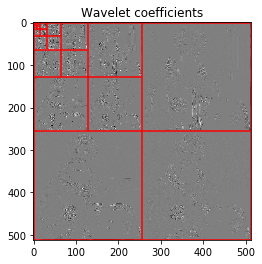

In [9]:
# Daubechies 10 filter
h = np.array([0, 0.160102397974, 0.603829269797, 0.724308528438, 0.138428145901, -0.242294887066, -0.032244869585, 0.077571493840, -0.006241490213, -0.012580751999, 0.003335725285])
h /= np.linalg.norm(h)

f_wavelet = wavelet_transform_2d(f, j_min=1, h=h)

plot_wavelet(f_wavelet, j_min=1)
plt.title('Wavelet coefficients')
plt.show()

----------------

**Question 5:** Using the function `inverse_wavelet_transform_2d`, compute a best $M$-term approximation in the wavelet basis of $f$, for
$M \in \{N/100, N/20\}$.

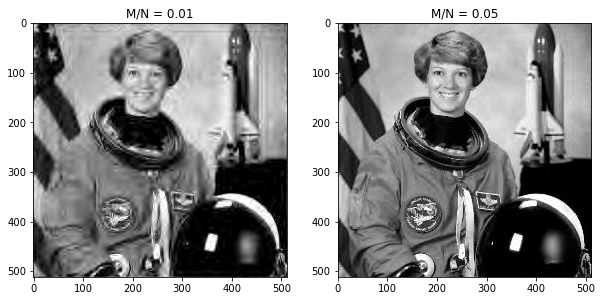

In [10]:
# Initialize the subplots.
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Define a threshold.
T = np.quantile(np.abs(f_wavelet), .99)

# Compute the reconstruction.
c = f_wavelet * (np.abs(f_wavelet) > T)
f_reconstructed = inverse_wavelet_transform_2d(c, j_min=1, h=h)

# Plot the reconstruction.
axes[0].set_title("M/N = %.2f" % np.mean(np.abs(f_wavelet) > T))
axes[0].imshow(f_reconstructed, cmap='gray', vmin=0, vmax=1)

# Define a threshold.
T = np.quantile(np.abs(f_wavelet), .95)

# Compute the reconstruction.
c = f_wavelet * (np.abs(f_wavelet) > T)
f_reconstructed = inverse_wavelet_transform_2d(c, j_min=1, h=h)

# Plot the reconstruction.
axes[1].set_title("M/N = %.2f" % np.mean(np.abs(f_wavelet) > T))
axes[1].imshow(f_reconstructed, cmap='gray', vmin=0, vmax=1)

# Display the supbplots.
plt.show()

---------

**Question 6:**
- Compute and display in log-scale the non-linear approximation error $\epsilon[M]^2$.
- Compare the Fourier and wavelets approximations.
- Store the values of $\epsilon[M]^2$ in a vector $err\_wav$.

/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


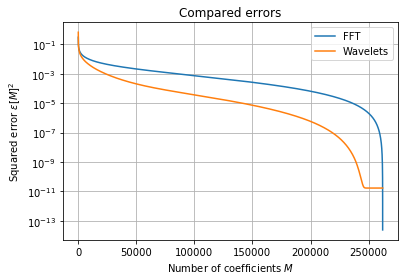

In [11]:
cR = np.sort(np.abs(f_wavelet).ravel())[::-1]
err_wav = np.sum(f**2) - np.cumsum(cR**2)

plt.title("Compared errors")
plt.xlabel("Number of coefficients $M$")
plt.ylabel("Squared error $\\varepsilon [M]^2$")
plt.plot(err_fft / np.sum(f**2))
plt.plot(err_wav / np.sum(f**2))
plt.legend(["FFT", "Wavelets"])
plt.yscale("log")
plt.grid()
plt.show()

Cosine Approximation
--------------------
The discrete cosine approximation (DCT) is similar to the Fourier
approximation, excepted that it used symmetric boundary condition instead
of periodic boundary condition, and is thus more useful to approximate
image.


A 1-D cosine atom of $n$ sample is defined as
$$ \bar\psi_m(x) = \frac{1}{\sqrt{N}} \cos\left( \frac{2\pi}{N} (x-1/2) m \right) $$
A 2-D cosine atom is obtained by tensor product of 1-D atoms
$$ \psi_{m_1,m_2}(x_1,x_2) = \bar\psi_{m_1}(x_1) \bar\psi_{m_2}(x_2). $$
On the contrary to the Fourier 2-D atoms, these 2-D DCT atoms are not
oriented (they contains 4 Fourier frequencies).


The set of inner products $ \{ \langle f, \psi_m\rangle \}_m $ is computed in
$O(N \log(N))$ operations with the 2-D Fast Cosine Transform
algorithm.

In [12]:
dct2 = lambda f: fftpack.dct(fftpack.dct(f, norm="ortho").T, norm="ortho").T
idct2 = lambda f: fftpack.idct(fftpack.idct(f, norm="ortho").T, norm="ortho").T

In [13]:
f_cosine = dct2(f)

-------------------

**Question 7:** Display the magnitude of the DCT coefficients.
Note that the low frequencies are in the upper-left corner.

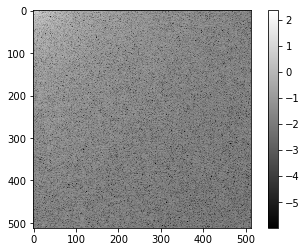

In [14]:
plt.imshow(np.log10(1e-6 + np.abs(f_cosine)), cmap="gray")
plt.colorbar()
plt.show()

--------------

**Question 8:** Compute a best $M$-term approximation in the wavelet basis of $f$, for
$M \in \{N/100, N/20\}$.

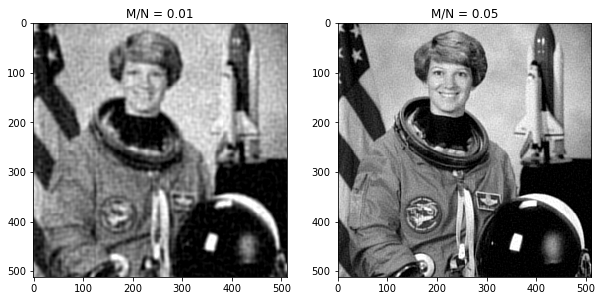

In [15]:
# Initialize the subplots.
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Define a threshold.
T = np.quantile(np.abs(f_cosine), .99)

# Compute the reconstruction.
c = f_cosine * (np.abs(f_cosine) > T)
f_reconstructed = idct2(c)

# Plot the reconstruction.
axes[0].set_title("M/N = %.2f" % np.mean(np.abs(f_cosine) > T))
axes[0].imshow(f_reconstructed, cmap='gray', vmin=0, vmax=1)

# Define a threshold.
T = np.quantile(np.abs(f_cosine), .95)

# Compute the reconstruction.
c = f_cosine * (np.abs(f_cosine) > T)
f_reconstructed = idct2(c)

# Plot the reconstruction.
axes[1].set_title("M/N = %.2f" % np.mean(np.abs(f_cosine) > T))
axes[1].imshow(f_reconstructed, cmap='gray', vmin=0, vmax=1)

plt.show()

---------

**Question 9:** Compute and display in log-scale the non-linear approximation
error $\epsilon[M]^2$. Compare the Fourier and DCT approximations. Store the values of $\epsilon[M]^2$ in a vector $err\_dct$.

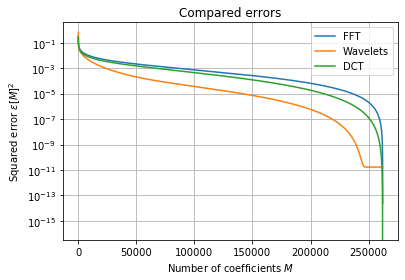

In [16]:
cR = np.sort(np.abs(f_cosine).ravel())[::-1]
err_dct = np.sum(f**2) - np.cumsum(cR**2)

plt.title("Compared errors")
plt.xlabel("Number of coefficients $M$")
plt.ylabel("Squared error $\\varepsilon [M]^2$")
plt.plot(err_fft / np.sum(f**2))
plt.plot(err_wav / np.sum(f**2))
plt.plot(err_dct / np.sum(f**2))
plt.legend(["FFT", "Wavelets", "DCT"])
plt.yscale("log")
plt.grid()
plt.show()

---------------

Local Cosine Approximation
--------------------------
To improve the global DCT approximation, one can approximate
independantly small patches in the image. This corresponds to a
decomposition in a local cosine basis, which is at the heart
of the JPEG image compression standard.


The only parameter of the transform is the size of the square.

In [17]:
w = 16

Initialize at zero the transformed image in the local DCT basis.

In [18]:
fL = np.zeros([n, n])

Example of patch index.

In [19]:
i = 5
j = 7

For a given path index $(i,j)$, we extract a $(w,w)$ patch.

In [20]:
P = f[i*w: (i+1)*w, j*w: (j+1)*w]

Compute the Cosine transform of the patch using the fast DCT algorithm.

In [21]:
fL[i*w: (i+1)*w, j*w: (j+1)*w] = dct2(P)

Display the patch and its coefficients. We removed the low frequency of
$P$ for display purpose only.

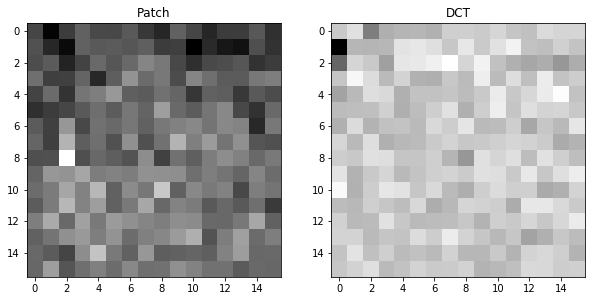

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].set_title("Patch")
axes[0].imshow(P, cmap="gray")

axes[1].set_title("DCT")
axes[1].imshow(dct2(P - np.mean(P)), cmap="gray")
plt.show()

-----------

**Question 10:** Compute the local DCT transform $f_L$ by transforming each patch and display it.

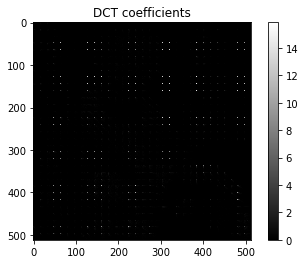

In [23]:
for i in range(n//w):
    for j in range(n//w):
        P = f[i*w: (i+1)*w, j*w: (j+1)*w]
        fL[i*w: (i+1)*w, j*w: (j+1)*w] = dct2(P)

plt.title("DCT coefficients")
plt.imshow(abs(fL), cmap="gray")
plt.colorbar()
plt.show()

------------

**Question 11:** Compute the inverse local DCT transform  of the coefficients $f_L$ by inverse
transforming each patch using  the function `idct2`.

In [24]:
f_reconstructed = np.zeros_like(fL)
for i in range(n//w):
    for j in range(n//w):
        P = fL[i*w: (i+1)*w, j*w: (j+1)*w]
        f_reconstructed[i*w: (i+1)*w, j*w: (j+1)*w] = idct2(P)

In [25]:
# Should be 0
np.linalg.norm(f - f_reconstructed) / np.linalg.norm(f)

2.120017084090918e-16

----------

**Question 11:** Compute the best $M$-term approximations in the Local DCT basis of $f$.

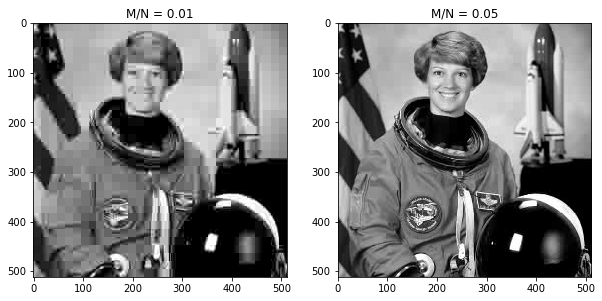

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

T = np.quantile(np.abs(fL), .99)
c = fL * (np.abs(fL) > T)
f_reconstructed = np.zeros_like(fL)
for i in range(n//w):
    for j in range(n//w):
        P = c[i*w: (i+1)*w, j*w: (j+1)*w]
        f_reconstructed[i*w: (i+1)*w, j*w: (j+1)*w] = idct2(P)
axes[0].set_title("M/N = %.2f" % np.mean(np.abs(fL) > T))
axes[0].imshow(f_reconstructed, cmap='gray', vmin=0, vmax=1)

T = np.quantile(np.abs(fL), .95)
c = fL * (np.abs(fL) > T)
f_reconstructed = np.zeros_like(fL)
for i in range(n//w):
    for j in range(n//w):
        P = c[i*w: (i+1)*w, j*w: (j+1)*w]
        f_reconstructed[i*w: (i+1)*w, j*w: (j+1)*w] = idct2(P)
axes[1].set_title("M/N = %.2f" % np.mean(np.abs(fL) > T))
axes[1].imshow(f_reconstructed, cmap='gray', vmin=0, vmax=1)

plt.show()

----------

**Question 12:** Compute and display in log-scale the non-linear approximation
error $\epsilon[M]^2$.
Store the values of $\epsilon[M]^2$ in a vector `err_ldct`.
Compare the Fourier, Wavelets, DCT and local-DCT approximations.

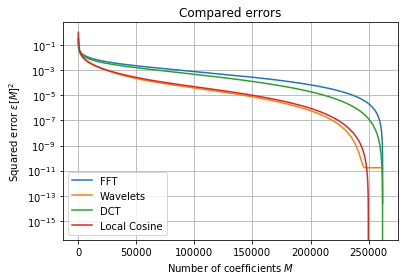

In [27]:
cR = np.sort(np.abs(fL).ravel())[::-1]
err_local = np.sum(f**2) - np.cumsum(cR**2)

plt.title("Compared errors")
plt.xlabel("Number of coefficients $M$")
plt.ylabel("Squared error $\\varepsilon [M]^2$")
plt.plot(err_fft / np.sum(f**2))
plt.plot(err_wav / np.sum(f**2))
plt.plot(err_dct / np.sum(f**2))
plt.plot(err_local / np.sum(f**2))
plt.legend(["FFT", "Wavelets", "DCT", "Local Cosine"])
plt.yscale("log")
plt.grid()
plt.show()